
Processing: evgeny_arbatov.parquet
Number of distance segments: 29982
Min distance: 0.94 m, Max distance: 266.62 m
Mean distance: 14.91 m, Std Dev: 13.80 m


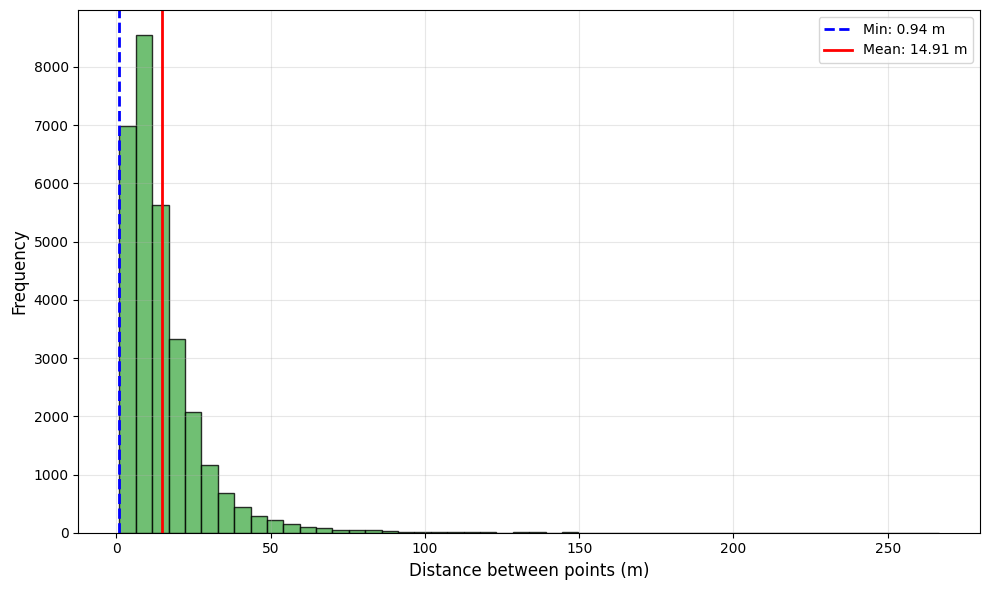

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from geopy.distance import geodesic  # For distance in km

# --- Configuration ---
content_dir = '/content'  # Folder with .parquet files
parquet_files = [f for f in os.listdir(content_dir) if f.endswith('.parquet')]

# Histogram color (green)
hist_color = '#4CAF50'

# --- Helper functions ---
def extract_route_coordinates(geometry):
    """Extract coordinates from a geometry as a list of (lat, lon) tuples."""
    if geometry is None or geometry.is_empty:
        return None
    return [(coord[1], coord[0]) for coord in geometry.coords]  # (lat, lon)

def compute_distances_meters(route):
    """Compute distances in meters between consecutive points in a route."""
    if route is None or len(route) < 2:
        return []
    distances = []
    for i in range(len(route) - 1):
        dist_m = geodesic(route[i], route[i+1]).km * 1000
        distances.append(dist_m)
    return distances

# --- Process each parquet file ---
for parquet_file in parquet_files:
    print(f"\nProcessing: {parquet_file}")
    file_path = os.path.join(content_dir, parquet_file)

    gdf = gpd.read_parquet(file_path)

    # Collect distances between points for all routes
    all_distances_m = []
    for geom in gdf.geometry:
        coords = extract_route_coordinates(geom)
        if coords is not None and len(coords) > 1:
            distances = compute_distances_meters(coords)
            all_distances_m.extend(distances)

    if len(all_distances_m) == 0:
        print(f"No valid routes in {parquet_file}")
        continue

    min_dist = min(all_distances_m)
    mean_dist = np.mean(all_distances_m)
    print(f"Number of distance segments: {len(all_distances_m)}")
    print(f"Min distance: {min_dist:.2f} m, Max distance: {max(all_distances_m):.2f} m")
    print(f"Mean distance: {mean_dist:.2f} m, Std Dev: {np.std(all_distances_m):.2f} m")

    # --- Plot distance distribution ---
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.hist(all_distances_m, bins=50, color=hist_color, alpha=0.8, edgecolor='black')

    # Add vertical red lines for min and mean distances
    plt.axvline(min_dist, color='blue', linestyle='--', linewidth=2, label=f'Min: {min_dist:.2f} m')
    plt.axvline(mean_dist, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_dist:.2f} m')

    plt.xlabel("Distance between points (m)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"/content/point_distances_m_{parquet_file[:-8]}.png", dpi=150, facecolor='white', bbox_inches='tight')
    plt.show()
    plt.close()
